# Korean News Summary Model

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

## Data

In [2]:
# Reviews.csv 파일을 data라는 이름의 데이터프레임에 저장. 단, 10만개의 행(rows)으로 제한.
data = pd.read_excel("종합 텍스트.xlsx")
print('전체 뉴스 개수 :',(len(data)))

전체 뉴스 개수 : 16983


In [3]:
data.head()

,기사번호,기사카테고리,매체유형,매체구분,매체명,기사대중소,기사본문글자수,발행일시,제목,내용,가독성,정확성,정보성,신뢰성,생성,추출1,추출2,추출3
0,371224146,종합,online,지역지,기호일보,medium,1436,2019-12-18 00:00:00,수사권 조정은 국민인권의 첫걸음,기호일보\n\n전영태 안산단원경찰서 112종합상황실/경위\n전영태 안산단원경찰서 1...,4,4,3,4,현 정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.,형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 ...,이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견...
1,363331583,종합,online,지역지,기호일보,small,898,2019-10-16 00:00:00,인천서 외래 해충 ‘소나무허리노린재’ 발생,최유탁 기자\n\n인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인\n임업...,4,4,4,4,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단'이 월미도와 인천대학...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는...,국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산...
2,363195607,종합,online,지역지,기호일보,small,747,2019-10-15 00:00:00,"김상희 의원 ""심평원 보험사기 방지 업무 민간 보험사 배불려""",최두환 기자\n\n건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 ...,4,5,4,4,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,더불어민주당 김상희(부천 소사) 국회원이 건강보험공단에서 확인한 자료에 따르면 심평...,문제는 이 돈이 건강보험 재정에서 나온다는 것이다.
3,357571415,종합,online,지역지,기호일보,small,757,2019-08-27 00:00:00,"부천시, ‘포도 수확 체험 프로그램’ 운영",부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,3,3,3,3,부천시는 포도를 수확하고 맛도 볼 수 있으며 수확한 포도(5kg)을 가져갈 수 있는...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,"가족 체험에 참여하면 포도 수확, 포도 맛보기 체험을 하고 수확한 포도(5㎏)를 가...","시 관계자는 ""도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소..."
4,368209875,종합,online,지역지,기호일보,small,767,2019-11-23 13:10:55,"가평군지사협, 어르신 짝쿵 초청 ‘힐링 문화소풍!’",엄건섭 기자\n\n가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신...,5,4,4,4,가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,23일 가평읍에 따르면 ‘힐링 문화소풍!’은 복지사각지대에 있는 지역 어르신들을 대...,"내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다""라..."


In [4]:
data = data[['내용','추출1', '추출2', '추출3']]
data.head()

,내용,추출1,추출2,추출3
0,기호일보\n\n전영태 안산단원경찰서 112종합상황실/경위\n전영태 안산단원경찰서 1...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.,형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 ...,이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견...
1,최유탁 기자\n\n인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인\n임업...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는...,국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산...
2,최두환 기자\n\n건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,더불어민주당 김상희(부천 소사) 국회원이 건강보험공단에서 확인한 자료에 따르면 심평...,문제는 이 돈이 건강보험 재정에서 나온다는 것이다.
3,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,"가족 체험에 참여하면 포도 수확, 포도 맛보기 체험을 하고 수확한 포도(5㎏)를 가...","시 관계자는 ""도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소..."
4,엄건섭 기자\n\n가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,23일 가평읍에 따르면 ‘힐링 문화소풍!’은 복지사각지대에 있는 지역 어르신들을 대...,"내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다""라..."


In [5]:
data['생성2'] = data[['추출1', '추출2']].apply(lambda x: ':'.join(x), axis=1)

In [6]:
data.head()

,내용,추출1,추출2,추출3,생성2
0,기호일보\n\n전영태 안산단원경찰서 112종합상황실/경위\n전영태 안산단원경찰서 1...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.,형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 ...,이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.:형사 사법제도의 본질은 ...
1,최유탁 기자\n\n인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인\n임업...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는...,국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...
2,최두환 기자\n\n건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,더불어민주당 김상희(부천 소사) 국회원이 건강보험공단에서 확인한 자료에 따르면 심평...,문제는 이 돈이 건강보험 재정에서 나온다는 것이다.,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,"가족 체험에 참여하면 포도 수확, 포도 맛보기 체험을 하고 수확한 포도(5㎏)를 가...","시 관계자는 ""도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소...",부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4,엄건섭 기자\n\n가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,23일 가평읍에 따르면 ‘힐링 문화소풍!’은 복지사각지대에 있는 지역 어르신들을 대...,"내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다""라...",가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...


In [7]:
data.dropna(axis=0, inplace=True)
data.shape

(16974, 5)

In [8]:
data['생성'] = data[['생성2', '추출3']].apply(lambda x: ':'.join(x), axis=1)
data.head()

,내용,추출1,추출2,추출3,생성2,생성
0,기호일보\n\n전영태 안산단원경찰서 112종합상황실/경위\n전영태 안산단원경찰서 1...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.,형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 ...,이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.:형사 사법제도의 본질은 ...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.:형사 사법제도의 본질은 ...
1,최유탁 기자\n\n인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인\n임업...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는...,국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...
2,최두환 기자\n\n건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,더불어민주당 김상희(부천 소사) 국회원이 건강보험공단에서 확인한 자료에 따르면 심평...,문제는 이 돈이 건강보험 재정에서 나온다는 것이다.,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,"가족 체험에 참여하면 포도 수확, 포도 맛보기 체험을 하고 수확한 포도(5㎏)를 가...","시 관계자는 ""도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소...",부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4,엄건섭 기자\n\n가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,23일 가평읍에 따르면 ‘힐링 문화소풍!’은 복지사각지대에 있는 지역 어르신들을 대...,"내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다""라...",가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...


In [9]:
del data["추출1"]
del data["추출2"]
del data["추출3"]
del data["생성2"]
data.shape

(16974, 2)

## Preprocessing

In [10]:
print('내용 열에서 중복을 배제한 유일한 샘플의 수 :', data['내용'].nunique())
print('생성 열에서 중복을 배제한 유일한 샘플의 수 :', data['생성'].nunique())

내용 열에서 중복을 배제한 유일한 샘플의 수 : 16973
생성 열에서 중복을 배제한 유일한 샘플의 수 : 16973


In [11]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['내용'], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 16973


In [12]:
print(data.isnull().sum())

내용    0
생성    0
dtype: int64


In [13]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 16973


In [14]:
# 한글 불용어
stopword = pd.read_csv('한국어불용어100.txt', sep = "\t", encoding = "utf-8", header=None)
stopword.loc[100] = ['기자', 'VX', 0.000483]
stop_words =  set(stopword[0])
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 95
{'위하', '씨', '대하', '데', '문제', '가', '한', '나', '그', '그렇', '나오', '지', '오', '따르', '있', '어떤', '생각하', '싶', '크', '안', '그녀', '하나', '없', '우리', '개', '수', '또', '이런', '좋', '번', '내', '명', '많', '하', '보이', '사람', '소리', '좀', '생각', '자신', '때', '잘', '사회', '지금', '등', '다시', '그런', '그러나', '여자', '다른', '시키', '보', '들', '때문', '되', '집', '알', '전', '같', '두', '통하', '말', '그것', '가지', '놓', '적', '년', '일', '월', '만들', '원', '정도', '주', '경우', '못하', '앞', '어떻', '살', '모르', '이렇', '속', '사실', '것', '점', '중', '받', '기자', '시간', '말하', '그러', '않', '아니', '이', '더', '그리고'}


In [15]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"▲\a","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[.,!?\"':;~()]", " ", sentence) # 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("r'[^ ㄱ-ㅣ가-힣A-Za-z]", " ", sentence)

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [16]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought was great infact ordered twice and the third ordered wasfor my mother and father
great way to start the day


In [18]:
# Text 열 전처리
clean_text = []
for s in data['내용']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['기호일보 전영태 안산단원경찰서 112종합상황실/경위 전영태 안산단원경찰서 112종합상황실 검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 대통령의 사법농단을 수사하느라 사법개혁특별위원회 구성이 늦어져 최근에 논의되고 있다 수사권 조정 지연은 제1야당의 소위원회 구성 비협조와 검찰의 미온적 태도로 현재까지 협상 중이다 그래서 대통령과 4당의 당대표 국회의원들이 수사권 조정을 통해 국민의 인권을 증진하고 검찰 권력의 폐해를 예방해 제왕적 권력을 분산하자는 것이다 그런데 검찰은 최근에 공수처법과 검경 수사권 조정안 등이 포함된 ‘패스트 트랙’ 국회 본회의 처리가 임박하자 검찰 간부들이 여야 의원을 불문하고 개별 접촉해 검찰개혁 법안 수정에 총력을 기울이는 것으로 알려졌다 고사성어 득롱망촉이라는 말이 있다 인간의 욕심은 한이 없어 권력에 한번 중독이 되면 마약과 같아서 끊임없이 쟁취하고 자신의 것을 지키기 위해 사람과도 타협하지 않는다고 한다 지금의 검찰이 그렇다 중국의 시진핑은 권력은 부패를 초래하고 절대 권력은 반드시 부패한다 라고 말했고 다산 정약용도 나라를 망하게 하는 것은 외침이 아니라 권력의 부정부패에 의한 민심의 이반이라고 경고했다 검찰의 모습은 한마디로 우이독경이다 국민의 대표인 국회의원과 대통령이 신속처리법안 개정의 보완이 필요하다고 하는데 검찰만이 아니라고 얘기하는 모습이 너무나 안쓰럽다 최근 검찰개혁에 대한 국민의 여론조사와 5월에 발간한 백년하청 검찰개혁 보고서에 의하면 검찰을 개혁해야 한다는 여론이 75% 이상 나왔다 이번에도 검찰개혁이 무산되면 무소불위의 검찰 공화국이 것이다 우리는 노무현 정부의 검찰과의 토론회나 정부의 수사권 조정 과정에서 검찰이 얼마나 힘이 센지 여실히 보았다 형사 사법제도의 본질은 경찰·검찰·법원 삼권 분립으로 상호 견제와 균형을 이뤄 대등한 관계에서 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다 하지만 우리의 현실은 검찰이 수사권 수사 지휘권 수사 종결권 영장 청구권 제왕적 권한을 갖고 있어 권력

In [19]:
# Summary 열 전처리
clean_summary = []
for s in data['생성']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 형사 사법제도의 본질은 경찰·검찰·법원 삼권 분립으로 상호 견제와 균형을 이뤄 대등한 관계에서 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다 이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 기관과의 상호 감시와 견제를 통해 국민의 인권을 증진하자는 것이다',
 '임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 ‘소나무허리노린재’가 인천지역 공원과 산림에서 확인했다 15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는 월미도와 인천대학교 송도캠퍼스 등에서 정착한 개체군을 확인했다 국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 예상된다',
 '건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 따른 심평원 설립 취지를 훼손시키고 있다는 지적이 대두됐다 더불어민주당 김상희 국회원이 건강보험공단에서 확인한 자료에 따르면 심평원은 2015년 이전부터 수사기관에서 의뢰가 들어오면 간간히 지원업무를 해오다 2015년 1월부터 전담부서인 공공심사부를 설치했으며 2016년 ‘보험사기방지 특별법’이 제정되면서 법에 따라 공식적으로 입원적정성 심사 업무를 수행해 왔다 문제는 돈이 건강보험 재정에서 나온다는 것이다',
 '부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 운영한다고 26일 밝혔다 가족 체험에 참여하면 포도 수확 포도 맛보기 체험을 하고 수확한 포도를 가져갈 있다 관계자는 도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소중한 추억이 것이라며 시민들이 우리 지역의 농업과 농촌을 이해하고 농산물을 믿고 구입하는 기회가 되길 바란다고 말했다',
 '가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 문화소풍’을 올해 마지막으로 추진했다 2

In [20]:
data['내용'] = clean_text
data['생성'] = clean_summary

In [21]:
# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

내용    0
생성    0
dtype: int64


In [22]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 16973


텍스트의 최소 길이 : 6
텍스트의 최대 길이 : 445
텍스트의 평균 길이 : 204.2093324692158
요약의 최소 길이 : 9
요약의 최대 길이 : 171
요약의 평균 길이 : 53.35674306251105


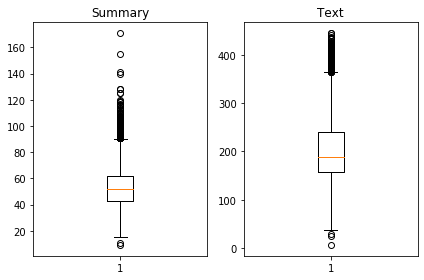

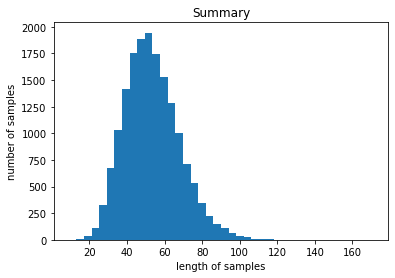

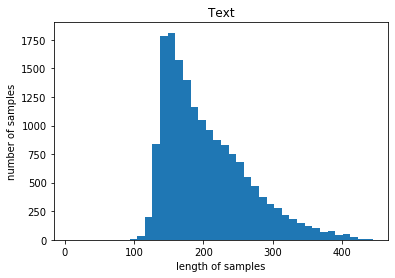

In [24]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['내용']]
summary_len = [len(s.split()) for s in data['생성']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
text_max_len = 300
summary_max_len = 60

In [26]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [28]:
below_threshold_len(text_max_len, data['내용'])

전체 샘플 중 길이가 300 이하인 샘플의 비율: 0.9198138219525128


In [29]:
below_threshold_len(summary_max_len, data['생성'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.7128380368821069


In [30]:
data = data[data['내용'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['생성'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 11098


In [31]:
data.head()

,내용,생성
1,최유탁 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 임업진흥원 외래 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을...
2,최두환 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3,부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 ...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4,엄건섭 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...
5,박지훈 전남도 6·25전쟁 69주년 기념식 유공자 22명 표창 6ㆍ25전쟁 제69주...,전남도와 목포시는 25일 목포문화예술회관에서 ‘6·25전쟁 제69주년 행사’를 열었...


In [32]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['내용'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['생성'].apply(lambda x : x + ' eostoken')
data.head()

,내용,생성,decoder_input,decoder_target
1,최유탁 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 임업진흥원 외래 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을...,sostoken 최유탁 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을...
2,최두환 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,sostoken 최두환 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3,부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 ...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,sostoken 부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4,엄건섭 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,sostoken 엄건섭 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...
5,박지훈 전남도 6·25전쟁 69주년 기념식 유공자 22명 표창 6ㆍ25전쟁 제69주...,전남도와 목포시는 25일 목포문화예술회관에서 ‘6·25전쟁 제69주년 행사’를 열었...,sostoken 박지훈 전남도 6·25전쟁 69주년 기념식 유공자 22명 표창 6ㆍ...,전남도와 목포시는 25일 목포문화예술회관에서 ‘6·25전쟁 제69주년 행사’를 열었...


In [33]:
encoder_input = np.array(data['내용'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [34]:
data.head()

,내용,생성,decoder_input,decoder_target
1,최유탁 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 임업진흥원 외래 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을...,sostoken 최유탁 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을...
2,최두환 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,sostoken 최두환 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3,부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 ...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,sostoken 부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4,엄건섭 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,sostoken 엄건섭 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...
5,박지훈 전남도 6·25전쟁 69주년 기념식 유공자 22명 표창 6ㆍ25전쟁 제69주...,전남도와 목포시는 25일 목포문화예술회관에서 ‘6·25전쟁 제69주년 행사’를 열었...,sostoken 박지훈 전남도 6·25전쟁 69주년 기념식 유공자 22명 표창 6ㆍ...,전남도와 목포시는 25일 목포문화예술회관에서 ‘6·25전쟁 제69주년 행사’를 열었...


## Split Data

In [35]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 9118  2376  4910 ...  9845 10799  2732]


In [36]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [37]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 2219


In [38]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [39]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 8879
훈련 레이블의 개수 : 8879
테스트 데이터의 개수 : 2219
테스트 레이블의 개수 : 2219


## Encoding

In [40]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [41]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 355817
등장 빈도가 6번 이하인 희귀 단어의 수: 324769
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 31048
단어 집합에서 희귀 단어의 비율: 91.27416621465528
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 29.248649383263853


In [42]:
src_vocab = 30000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [43]:
print(encoder_input_train[:3])

[[27231, 17012, 11205, 209, 5677, 4564, 21904, 127, 66, 496, 27232, 21905, 1256, 112, 18378, 3530, 201, 12, 11206, 1434, 12436, 41, 1174, 2584, 2585, 37, 10652, 21905, 45, 898, 2743, 151, 1, 8286, 1476, 21904, 21905, 1435, 3054, 1284, 1371, 74, 929, 369, 10, 319, 45, 266, 8000, 9705, 3530, 201, 1174, 2584, 2585, 37, 54, 27233, 4, 4071, 1418, 67, 5397, 310, 898, 3752, 12437, 21904, 21905, 12438, 227, 3610, 2219, 10653, 1434, 15817, 174, 1910, 203, 4789, 18379, 24283, 226, 1419, 11768, 1400, 12, 2110, 21905, 1093, 198, 15818, 29, 386, 1604, 1304, 24284, 11769, 487, 17, 898, 17013, 22, 3675, 56, 646, 27234, 109, 56, 1539, 13901, 75, 14746, 7472, 275, 74, 21906, 2193, 22, 10654, 7473, 14747, 540, 3675, 533, 1710, 348, 1776, 268, 17, 823, 545, 39, 78, 79, 11770, 109, 56, 17014, 14748, 564, 2481, 13134, 61, 3823, 209, 8926, 2193, 496, 27232, 21904, 21905, 6347, 19988, 19, 1529, 935, 3165, 248, 3675, 1239, 935, 435, 102, 677, 10655, 143, 7725, 17015, 843, 5527, 133, 21907, 66], [313, 657, 158

In [44]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [45]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 355818
등장 빈도가 5번 이하인 희귀 단어의 수: 319616
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 36202
단어 집합에서 희귀 단어의 비율: 89.82569740710137
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 27.31213363494801


In [46]:
tar_vocab = 30000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [47]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [48]:
print(decoder_input_train[:5])

[[3, 29854, 17171, 12648, 221, 6111, 5067, 20968, 123, 67, 463, 29855, 20969, 1237, 121, 17172, 3621, 226, 10, 11604, 1380, 12139, 35, 1238, 2626, 2541, 40, 10303, 20969, 43, 874, 2507, 150, 1, 6744, 1364, 20968, 20969, 1204, 3039, 1442, 1332, 85, 1133, 429, 7, 348, 43, 239, 27007, 7915, 8984, 3621, 226, 1238, 2626, 2541, 40, 59, 22709, 6, 4134, 1321, 72, 5187, 228, 874, 3936, 13243, 20968, 20969, 12140, 265, 3561, 2281, 11605, 1380, 15317, 169, 1538, 196, 4692, 18267, 27008, 245, 1478, 12649, 1443, 10, 2172, 20969, 1067, 192, 17173, 31, 339, 1553, 1493, 24694, 11606, 486, 20, 874, 17174, 28, 3170, 58, 611, 27009, 122, 58, 1766, 14560, 81, 17175, 8711, 275, 85, 24695, 2477, 28, 10711, 8163, 16199, 509, 3170, 503, 1681, 349, 1723, 255, 20, 751, 29856, 571, 42, 70, 78, 12141, 122, 58, 19530, 17176, 572, 2542, 12650, 64, 4071, 221, 9289, 2477, 463, 29855, 20968, 20969, 5983, 18268, 22, 1526, 1034, 3040, 279, 3170, 1333, 1034, 404, 98, 672, 9930, 148, 7916, 18269, 838, 5188, 159, 18270, 67

In [49]:
print(decoder_target_train[:5])

[[10303, 20969, 43, 874, 1860, 2507, 150, 1, 20968, 20969, 12140, 265, 3561, 2281, 11605, 1380, 15317, 169, 1538, 3170, 1333, 1034, 404, 98, 672, 9930, 148, 7916, 18269, 838, 5188, 159, 18270, 67, 4], [737, 29857, 7723, 172, 112, 661, 43, 418, 218, 2902, 10712, 103, 11607, 661, 1280, 24696, 19, 2688, 940, 26, 2719, 2435, 104, 124, 828, 11117, 1291, 10712, 103, 5619, 16200, 4], [29858, 4878, 8, 699, 8, 1822, 892, 772, 15319, 269, 29858, 4878, 8, 7, 193, 1159, 637, 8164, 699, 4878, 8, 303, 2659, 5068, 365, 56, 1554, 440, 1843, 618, 4506, 29859, 221, 10713, 29, 4], [785, 2903, 6919, 958, 5285, 5069, 22712, 19532, 352, 1456, 774, 24701, 19533, 303, 2720, 1096, 303, 3678, 18273, 10714, 21, 5189, 99, 127, 210, 328, 1240, 1612, 5286, 6919, 201, 958, 5285, 14565, 5069, 165, 8986, 27014, 1180, 4], [472, 1799, 18274, 325, 19537, 200, 117, 30, 4598, 5072, 418, 294, 258, 21, 24, 146, 206, 44, 2563, 488, 1210, 455, 29861, 13851, 943, 488, 4434, 286, 37, 488, 246, 5, 23, 173, 7305, 233, 17178, 932, 

## Remove Empty Samples

In [50]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [51]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [52]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 8879
훈련 레이블의 개수 : 8879
테스트 데이터의 개수 : 2219
테스트 레이블의 개수 : 2219


## Padding

In [53]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## Seq2Seq + Attention Summary Model

In [54]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [55]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [56]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [57]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 128)     3840000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [58]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [59]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 128)     3840000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [60]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 5)

Train on 8879 samples, validate on 2219 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
8879/8879 [==============================] - 11412s 1s/sample - loss: 6.1474 - val_loss: 5.1643
Epoch 2/5
8879/8879 [==============================] - 16004s 2s/sample - loss: 5.4238 - val_loss: 5.1605
Epoch 3/5
8879/8879 [==============================] - 17141s 2s/sample - loss: 5.3715 - val_loss: 5.1103
Epoch 4/5
8879/8879 [==============================] - 17622s 2s/sample - loss: 5.3165 - val_loss: 5.0994
Epoch 5/5
8704/8879 [============================>.] - ETA: 5:36 - loss: 5.2314 

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluation

In [114]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [115]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [116]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [117]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [118]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [119]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [120]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  disappointing purchase two packages opened noodles fell apart many tiny pieces water bought noodles never happen guessing damage shipping 
실제 요약문 : in the water 
예측 요약문 :  not bad


원문 :  product along lines hamburger helper remember eating kid wanted try product liquid gold orzo pasta nice treat broccoli joke small little freeze dried broccoli cheese sauce strong smell mixed rest ingredients lost taste loved overall okay nothing special better making scratch 
실제 요약문 : kraft chicken and broccoli dinner kit 
예측 요약문 :  not what expected


원문 :  tried many kinds coffee keep coming back newman love ordering amazon coffee right door cannot beat 
실제 요약문 : best coffee in 
예측 요약문 :  great coffee


원문 :  healthy tasty portable packets great go perfect gym bag cannot around fresh next best option pear mango flavor texture smooth applesauce recently packed work trip good way add little something healthy hotel fast food often dominate comes business travel 
실제 요약문 : great snack for adults 
예

예측 요약문 :  great product


원문 :  yr old english usually bully sticks pet store visit found bones try fabulous awful smell keeps focused hours different layers bone keep interested read another review dog threw bone dogs sensitive skin stomachs never issue expensive bones well worth quality staying power 
실제 요약문 : excellent for chewers 
예측 요약문 :  great for my dog


원문 :  highland sugarworks organic maple syrup far best maple syrup daughter tasted tried many brands including maple syrup produced individuals syrup best opportunity purchase months ago amazon com unfortunately price gone like everything else grocery related good hesitate try brands want disappointed buying near future 
실제 요약문 : maple syrup 
예측 요약문 :  great product


원문 :  happy found product amazon saved ton money share homemade chinese hot mustard family friends great product great price 
실제 요약문 : wow bargain for sure 
예측 요약문 :  great product


원문 :  coffee smooth rather flat compared starbuck brews bite like mild coffee en

예측 요약문 :  great taste


원문 :  pocket coffee delicious make sure put whole thing mouth biting center mouth get enjoy espresso center chocolate one fantastic bite make great gift non coffee drinkers drink coffee love pocket coffee 
실제 요약문 : delicious 
예측 요약문 :  great coffee


원문 :  loves month old loves mixtures great job promised would never feed something would eat taste good would eat inclined eat pureed meal easy pack throw diaper back suit case travel worry leaking price right shipping quick store really well pantry ready made box happy baby happy mommy 
실제 요약문 : taste or two 
예측 요약문 :  my dog loves these


원문 :  served tea lake canada found good look returned home good minus mountain view course speedy delivery great wait days 
실제 요약문 : great tea 
예측 요약문 :  great tea


원문 :  tasty keeps eating junk food meals perfect diabetic snack 
실제 요약문 : addictive 
예측 요약문 :  great


원문 :  love extract good flavor overpowering use shakes need little extra something buy 
실제 요약문 : very nice 
예측 요약

예측 요약문 :  not bad


원문 :  think thin great meal sweet sweet enough stop cravings 
실제 요약문 : think thin 
예측 요약문 :  great


원문 :  offer well worth working either high pressure sodium metal cost much run cool make little noise others run friendly actually efficient beating even bulbs 
실제 요약문 : solid 
예측 요약문 :  great product


원문 :  cannot say enough good things absolutely yummy healthy cereal sweet story behind creation love love love love crunch dark chocolate red berries 
실제 요약문 : love love crunch 
예측 요약문 :  great snack


원문 :  dog loves treats happy find amazon look elsewhere next time due fact amazon price almost double sellers 
실제 요약문 : dog favorite treat 
예측 요약문 :  great product


원문 :  tried share snack breakfast bars busy always looking easy quick meal quaker oat soft baked bar best ever eaten tried banana nut bread flavor delicious yummy baked fresh kitchen 
실제 요약문 : delicious quick easy snack 
예측 요약문 :  great snack


원문 :  bars good really surprised even better take suggestion he

예측 요약문 :  not as good as


원문 :  food loved easy take us go road trips 
실제 요약문 : great food 
예측 요약문 :  great product


원문 :  love product ive tried several different options one best unlike people cups strong make however want husband use cups products ive tried dont filter good enough one like able throw away im done little pricey mostly shipping costs worth 
실제 요약문 : love this product 
예측 요약문 :  great coffee


원문 :  like soda made fruit juice misleading pomegranate also apple white grape pineapple lemon cranberry last list pomegranate like sweet soda probably like since tart surprised tart good fizz calories per cans oz smaller types refreshing would recommend soda since healthy alternative types soda 
실제 요약문 : nice change 
예측 요약문 :  great taste


원문 :  excellent price good coffee enjoy leave little fine grounds bottom though 
실제 요약문 : very good coffee 
예측 요약문 :  great coffee


원문 :  came timely manner pleased order comments comments comments comments 
실제 요약문 : ring pops 
예측 요약문 :  g

예측 요약문 :  great product


원문 :  purchased types blue diamond almonds day around pack one one oz container assumed least containers since cost 
실제 요약문 : you are only getting one container 
예측 요약문 :  not bad


원문 :  two love treats well packaged little big large break half large medium size dog would fine may need take hammer smaller dogs break pieces sure come smaller size really like used organic products organic freak notice taste freshness difference organic food dogs deserve 
실제 요약문 : what can say dogs love these 
예측 요약문 :  my dog loves these


원문 :  would even think buying product unless know price per unit compare items online store 
실제 요약문 : what quantity is it 
예측 요약문 :  great product


원문 :  usually rotate several brands moist dog food keep breakfast interesting product wonderful hand dog loves moist food normally stock plan away friend tends pet extremely quick easy tear empty toss individual packets glad amazon sells since many grocers seem offer individual packets 
실제 요약문 : 

예측 요약문 :  great product


원문 :  tryed gravy mixes nothing compares others flavor since cannot buy stores town continue order amazon 
실제 요약문 : awesome 
예측 요약문 :  great product


원문 :  shocked quickly received order could believe good brings back many memories childhood italian family sitting around table eating beans oregano red pepper salt always rinse couple time bottled juice could wait hours pass 
실제 요약문 : outstanding quality 
예측 요약문 :  great taste


원문 :  dog second doctor suggested grain free cooked diet years initial diagnosis people cannot believe age ever sick product arrives consistently well packed quality food consistent admit dog healthier diet 
실제 요약문 : the best thing have done for my dog 
예측 요약문 :  my dog loves these


원문 :  best chips eaten popped instead fried baked makes easier weight love love 
실제 요약문 : pop chips original chips 
예측 요약문 :  great chips


원문 :  placed around house several days setup fly trap literally watched flies avoid trap days excited see one lil lan

예측 요약문 :  great popcorn


원문 :  melitta blend nice light coffee suitable anytime day particularly great drinking night decaffeinated texture nice acidic taste anything meant casual drinkers prefer coffee darker caffine enjoy blend would recommend giving try judge 
실제 요약문 : great to drink after dinner 
예측 요약문 :  great coffee


원문 :  like espresso probably like coffee taste strong bold mildly sweetened one contains calories mg caffeine yikes lot caffeine like coffee strong drinking fyi product 
실제 요약문 : packs strong punch 
예측 요약문 :  great coffee


원문 :  really got flavors right accompany green tea slightly sweet slightly spicy aromatic plain delicious like fruit teas highly recommend one 
실제 요약문 : really delicious fruit blend tea 
예측 요약문 :  great tea


원문 :  coconut oil wonderful product price point get fairly good quality oil scent natural light oil skin leaving soft delivery prompt wonderful product shopping experience highly recommended 
실제 요약문 : great product 
예측 요약문 :  great product

예측 요약문 :  great coffee


원문 :  tully cups delicious tried several different flavors pleased full bodied taste one favorites kona blend offers satisfying cup coffee time never go back old coffee pots ever 
실제 요약문 : star coffee 
예측 요약문 :  great coffee


원문 :  mediocre health drink price mental thing japan per expensive available course amazon japan per save money buy something local basically drinking curry powder yeah people insane enough believe serious health energy benefits sure price also seems reasonable people 
실제 요약문 : is amazon serious 
예측 요약문 :  great product


원문 :  yes fabulous hard stop eating serving size tried bunch different varieties think blueberry pomegranate best unfortunately costco carrying anymore least happy purchased online 
실제 요약문 : on the yummo 
예측 요약문 :  great taste


원문 :  due weather conditions hawaii hard find brand cup stores delighted find amazon arrived quickly excellent quality thank much 
실제 요약문 : tully kona blend coffee 
예측 요약문 :  great product


원문 :

예측 요약문 :  cats love it


원문 :  great dressing wet food get ill cat eat enough keep weight attracted cans open flakes top eat everything sticking real life saver without much protein 
실제 요약문 : gets my cat to eat 
예측 요약문 :  my cats love it


원문 :  price item three times would pay store 
실제 요약문 : do not buy this item 
예측 요약문 :  great product


원문 :  two years age love happy hips chicken banana variety favorite try 
실제 요약문 : my dogs love them 
예측 요약문 :  great product


원문 :  love olives think taste slightly subtle would like still good chips light crispy sturdy used dipping salty seems like healthy snack really curious try flavors well brand quality product enjoy 
실제 요약문 : good 
예측 요약문 :  great snack


원문 :  taste great great texture year old little interest eating fresh vegetables loves actually prefers goldfish crackers products nutritional value fact worth expense worth cost get eat vegetables 
실제 요약문 : great way to get kids to eat 
예측 요약문 :  great product


원문 :  much richer taste sens

예측 요약문 :  great product


원문 :  children brought bottle vanilla visiting mexico great stuff actually find due concentration flavor generally use amount called recipes glass bottle makes terrific vase decoration emptied 
실제 요약문 : great stuff 
예측 요약문 :  great product


원문 :  excellent quality use curries time also gives great fragrance steamed rice better getting powder loses aroma flavor rapidly put quarter airtight jar spice cabinet froze rest easily mortar seconds simple use often 
실제 요약문 : it the flavor 
예측 요약문 :  great product


원문 :  tea okay hoped seems though low quality tea leaves used definite lack depth flavor left steep much longer time normal flavor brands would really recommend brand love type tea 
실제 요약문 : not what had hoped for 
예측 요약문 :  great tea


원문 :  dog loves treat made usa really small bag pricey 
실제 요약문 : expensive but great treats 
예측 요약문 :  great product


원문 :  three year old daughter drinking brand goat milk last years dairy intolerant great product easy carr

예측 요약문 :  great product


원문 :  give pet tasty organic treats discovered laughing dog street fair giving free samples away happy dogs staff friendly answered questions looking get special treat dog really try 
실제 요약문 : yummy organic dog treats 
예측 요약문 :  my dog loves these


원문 :  husband likes hot spicy foods really uses lot various foods 
실제 요약문 : my husband loves this product 
예측 요약문 :  great


원문 :  wonderful great buy money easy cook healthy rich nutty flavor would recommend everyone 
실제 요약문 : oats 
예측 요약문 :  great product


원문 :  around great experience ordering dog food great price fast shipping 
실제 요약문 : great 
예측 요약문 :  great product


원문 :  tried different brands different roasts including gourmet coffees always keep coming back folgers classic offers smooth relatively full bodied flavor without overpowering bitter happily usually among lower priced coffees buy price alone added bonus 
실제 요약문 : folgers classic roast is my favorite coffee 
예측 요약문 :  great coffee


원문 :  first 

예측 요약문 :  great taste


원문 :  buying treats year lab looks forward treat finishing meal mention happy hips watch smile 
실제 요약문 : healthy dog snack 
예측 요약문 :  great product


원문 :  great transaction anyone ship address support military 
실제 요약문 : old soy ginger dressing 
예측 요약문 :  great product


원문 :  beautiful popcorn popped sitting shelf waiting popped white yellow making bowl look appealing hulls explode amazing never popcorn great deal glad bought pack worked lb think people gave bad review must gotten bad batch awesome 
실제 요약문 : yummy and pretty 
예측 요약문 :  great popcorn


원문 :  favorite jelly beans get candy store period huge fan cinnamon candy best found love hot well good strong cinnamon flavor jelly belly jelly beans lasts past first bite love 
실제 요약문 : hot by the 
예측 요약문 :  great product


